In [13]:
%pylab inline
import re
import math
import string
from collections import Counter
from __future__ import division
import random
import numpy as np

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/andrewlauer/miniconda3/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random', 'sample']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [14]:
def test_function():
    print("hello world")

In [15]:
file = open("big.txt","r")
TEXT = file.read()
len(TEXT)

6488666

In [16]:
def tokens(text):
    "List all the word tokens (consecutive letters) in a text. Normalize to lowercase."
    return re.findall('[a-z]+', text.lower()) 

In [17]:
tokens('This is: A test, 1, 2, 3, this is.')

['this', 'is', 'a', 'test', 'this', 'is']

In [18]:
WORDS = tokens(TEXT)
len(WORDS)

1105285

In [19]:
def sample(bag, n=10):
    "Sample a random n-word sentence from the model described by the bag of words."
    return ' '.join(random.choice(bag) for _ in range(n))

In [20]:
sample(WORDS)

'god suggested in of nice injurious a war only into'

In [21]:
Counter(tokens('Is this a test? It is a test!'))

Counter({'is': 2, 'this': 1, 'a': 2, 'test': 2, 'it': 1})

In [22]:
COUNTS = Counter(WORDS)

print(COUNTS.most_common(10))

[('the', 80030), ('of', 40025), ('and', 38313), ('to', 28766), ('in', 22050), ('a', 21155), ('that', 12512), ('he', 12401), ('was', 11410), ('it', 10681)]


In [23]:
for w in tokens('the rare and neverbeforeseen words'):
    print(COUNTS[w], w)

80030 the
83 rare
38313 and
0 neverbeforeseen
460 words


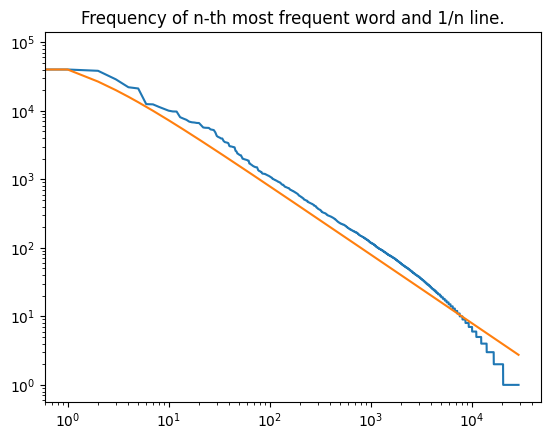

In [24]:
M = COUNTS['the']
yscale('log'); xscale('log'); title('Frequency of n-th most frequent word and 1/n line.')
plot([c for (w, c) in COUNTS.most_common()])
plot([M/i for i in range(1, len(COUNTS)+1)]);

In [25]:
def correct(word):
    "Find the best spelling correction for this word."
    # Prefer edit distance 0, then 1, then 2; otherwise default to word itself.
    candidates = (known(edits0(word)) or 
                  known(edits1(word)) or 
                  known(edits2(word)) or 
                  [word])
    return max(candidates, key=COUNTS.get)

def known(words):
    "Return the subset of words that are actually in the dictionary."
    return {w for w in words if w in COUNTS}

def edits0(word): 
    "Return all strings that are zero edits away from word (i.e., just word itself)."
    return {word}

def edits2(word):
    "Return all strings that are two edits away from this word."
    return {e2 for e1 in edits1(word) for e2 in edits1(e1)}

def edits1(word):
    "Return all strings that are one edit away from this word."
    pairs      = splits(word)
    deletes    = [a+b[1:]           for (a, b) in pairs if b]
    transposes = [a+b[1]+b[0]+b[2:] for (a, b) in pairs if len(b) > 1]
    replaces   = [a+c+b[1:]         for (a, b) in pairs for c in alphabet if b]
    inserts    = [a+c+b             for (a, b) in pairs for c in alphabet]
    return set(deletes + transposes + replaces + inserts)

def splits(word):
    "Return a list of all possible (first, rest) pairs that comprise word."
    return [(word[:i], word[i:]) 
            for i in range(len(word)+1)]

alphabet = 'abcdefghijklmnopqrstuvwxyz'

In [26]:
print(*map(correct, tokens('srbgr')))

saber


In [43]:
print(*map(correct, tokens('desslnq')))

desslnq


In [28]:
def correct_text(text):
    "Correct all the words within a text, returning the corrected text."
    return re.sub('[a-zA-Z]+', correct_match, text)

def correct_match(match):
    "Spell-correct word in match, and preserve proper upper/lower/title case."
    word = match.group()
    return case_of(word)(correct(word.lower()))

def case_of(text):
    "Return the case-function appropriate for text: upper, lower, title, or just str."
    return (str.upper if text.isupper() else
            str.lower if text.islower() else
            str.title if text.istitle() else
            str)

# Now for a more NLP based model

In [29]:
import scipy.spatial.distance as ssd 
def pdist(counter):
    "Make a probability distribution, given evidence from a Counter."
    # N = sum(counter.values())
    # return lambda x: counter[x]/N
    N = 0
    for x in counter:
        N += counter[x]
    dictionary = {}
    for x in counter:
        dictionary[x] = counter[x] / N
    return dictionary

P = pdist(COUNTS)

In [30]:
def memo(f):
    "Memoize function f, whose args must all be hashable."
    cache = {}
    def fmemo(*args):
        if args not in cache:
            cache[args] = f(*args)
        return cache[args]
    fmemo.cache = cache
    return fmemo

In [31]:
max(len(w) for w in COUNTS)

18

In [32]:
def splits(text, start=0, L=20):
    "Return a list of all (first, rest) pairs; start <= len(first) <= L."
    return [(text[:i], text[i:]) 
            for i in range(start, min(len(text), L)+1)]

In [33]:
print(splits('word'))
print(splits('reallylongtext', 1, 4))

[('', 'word'), ('w', 'ord'), ('wo', 'rd'), ('wor', 'd'), ('word', '')]
[('r', 'eallylongtext'), ('re', 'allylongtext'), ('rea', 'llylongtext'), ('real', 'lylongtext')]


In [34]:
def load_counts(filename, sep='\t'):
    """Return a Counter initialized from key-value pairs, 
    one on each line of filename."""
    C = Counter()
    for line in open(filename):
        key, count = line.split(sep)
        C[key] = int(count)
    return C

In [35]:
#COUNTS1 = load_counts('count_1w.txt')
#COUNTS2 = load_counts('count_2w.txt', ':')

#P1w = pdist(COUNTS1)
#P2w = pdist(COUNTS2)

In [36]:
"""
sum1 = np.sum(COUNTS1[item] for item in COUNTS1)
sum2 = np.sum(COUNTS2[item] for item in COUNTS2)
print(len(COUNTS1), sum1/1e9)
print(len(COUNTS2), sum2/1e9)
"""

'\nsum1 = np.sum(COUNTS1[item] for item in COUNTS1)\nsum2 = np.sum(COUNTS2[item] for item in COUNTS2)\nprint(len(COUNTS1), sum1/1e9)\nprint(len(COUNTS2), sum2/1e9)\n'

In [37]:
#COUNTS2.most_common(30)

In [38]:
"""
def product(nums):
    "Multiply the numbers together.  (Like `sum`, but with multiplication.)"
    result = 1
    for x in nums:
        result *= x
    return result

def Pwords2(words, prev='<S>'):
    "The probability of a sequence of words, using bigram data, given prev word."
    return product(cPword(w, (prev if (i == 0) else words[i-1]))
                   for (i, w) in enumerate(words))

# Change Pwords to use P1w (the bigger dictionary) instead of Pword
def Pwords(words):
    "Probability of words, assuming each word is independent of others."
    return product(P1w[w] for w in words)

def cPword(word, prev):
    "Conditional probability of word, given previous word."
    bigram = prev + ' ' + word
    try:
        if P2w[bigram] > 0 and P1w[prev] > 0:
            return P2w[bigram] / P1w[prev]
        else: # Average the back-off value and zero.
            return P1w[word] / 2
    except KeyError:
        return 0
"""

'\ndef product(nums):\n    "Multiply the numbers together.  (Like `sum`, but with multiplication.)"\n    result = 1\n    for x in nums:\n        result *= x\n    return result\n\ndef Pwords2(words, prev=\'<S>\'):\n    "The probability of a sequence of words, using bigram data, given prev word."\n    return product(cPword(w, (prev if (i == 0) else words[i-1]))\n                   for (i, w) in enumerate(words))\n\n# Change Pwords to use P1w (the bigger dictionary) instead of Pword\ndef Pwords(words):\n    "Probability of words, assuming each word is independent of others."\n    return product(P1w[w] for w in words)\n\ndef cPword(word, prev):\n    "Conditional probability of word, given previous word."\n    bigram = prev + \' \' + word\n    try:\n        if P2w[bigram] > 0 and P1w[prev] > 0:\n            return P2w[bigram] / P1w[prev]\n        else: # Average the back-off value and zero.\n            return P1w[word] / 2\n    except KeyError:\n        return 0\n'

In [39]:
#print(Pwords(tokens('this is a test')))
#print(Pwords2(tokens('this is a test')))


In [40]:
"""
@memo 
def segment2(text, prev='<S>'): 
    "Return best segmentation of text; use bigram data." 
    if not text: 
        return []
    else:
        candidates = ([first] + segment2(rest, first) 
                      for (first, rest) in splits(text, 1))
        return max(candidates, key=lambda words: Pwords2(words, prev))
"""

'\n@memo \ndef segment2(text, prev=\'<S>\'): \n    "Return best segmentation of text; use bigram data." \n    if not text: \n        return []\n    else:\n        candidates = ([first] + segment2(rest, first) \n                      for (first, rest) in splits(text, 1))\n        return max(candidates, key=lambda words: Pwords2(words, prev))\n'

In [41]:
"""
print(segment2('choosespain'))
print(segment2('speedofart'))
print(segment2('smallandinsignificant'))
print(segment2('largeandinsignificant'))
"""

"\nprint(segment2('choosespain'))\nprint(segment2('speedofart'))\nprint(segment2('smallandinsignificant'))\nprint(segment2('largeandinsignificant'))\n"